## 1. Reading the data

### Package imports

In [6]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

### Reading the images present in the 'dataset/sans/16x' directory (dataset-1)

In [13]:
data=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())


### Displaying the input images

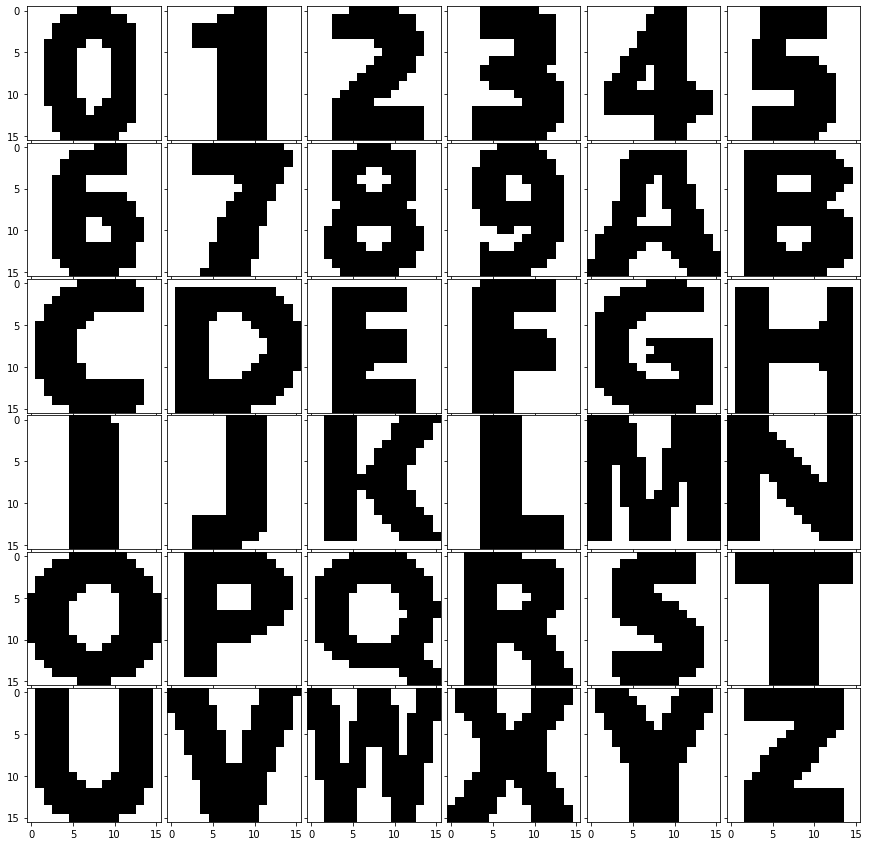

In [14]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(data[i].reshape(16, 16), 'gray')    

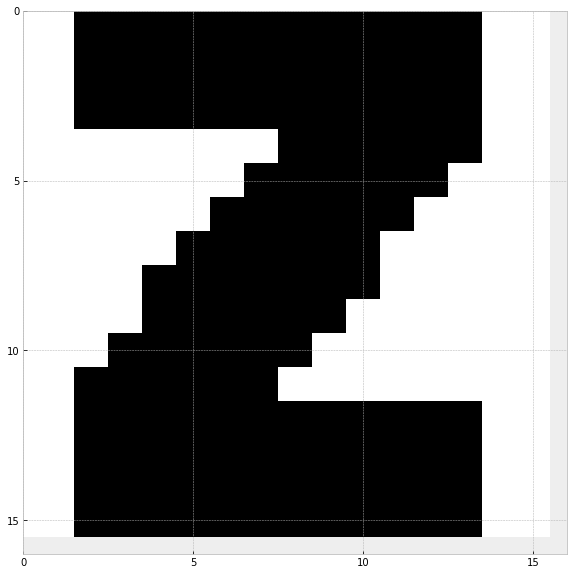

In [15]:
plt.style.use('bmh')
plt.figure(figsize=(10, 10))
plt.xticks(range(0, 16, 5))
plt.ylim(16, 0)
plt.xlim(0, 16)
plt.yticks(range(0, 16, 5))
plt.imshow(data[35].reshape(16, 16), 'gray')

In [16]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))

/var/folders/_r/kf286j851_3d6kcr8bbjwbdm0000gn/T/ipykernel_1891/1365032627.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_data = Variable(torch.Tensor([data]))


## 2. Model Designing and Training

In [24]:
from model import DeepNet
from engine import test, train

# metrics for measuring the performance of the model
ffa = []
fh = []


for epochs in range(0, 1100, 100):
    model = DeepNet(layerSize=[256]+[256]*3+[256])
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    
    #Train the model with MSE loss criterion and Adam optimizer function
    train(data, data, model, criterion, optimizer, epochs)
    
    # Compute errors and predicted output 
    pred, err = test(data=data, target=data, model=model)
    fh += [np.mean(err[0])]
    ffa += [np.mean(err[1])]
    print("Epochs {}: FFA {} and FH {}".format(epochs, ffa[-1], fh[-1]))

Epochs 0: FFA 0.45876315277033164 and FH 0.45516355750247395
Epochs 100: FFA 0.05081698260683842 and FH 0.9701949659429461
Epochs 200: FFA 0.013240082124419135 and FH 0.9912910334808179
Epochs 300: FFA 0.011820132461488914 and FH 0.9922902970378722
Epochs 400: FFA 0.011453317090916423 and FH 0.9942050250266886
Epochs 500: FFA 0.010154337147646424 and FH 0.9940830285696948
Epochs 600: FFA 0.00733841078032912 and FH 0.9941811211874649
Epochs 700: FFA 0.006863416456036341 and FH 0.9955419616090698
Epochs 800: FFA 0.008948901325130584 and FH 0.9969804834887799
Epochs 900: FFA 0.012561696159760894 and FH 0.9950303034321961
Epochs 1000: FFA 0.008112245818217456 and FH 0.9948824786161428


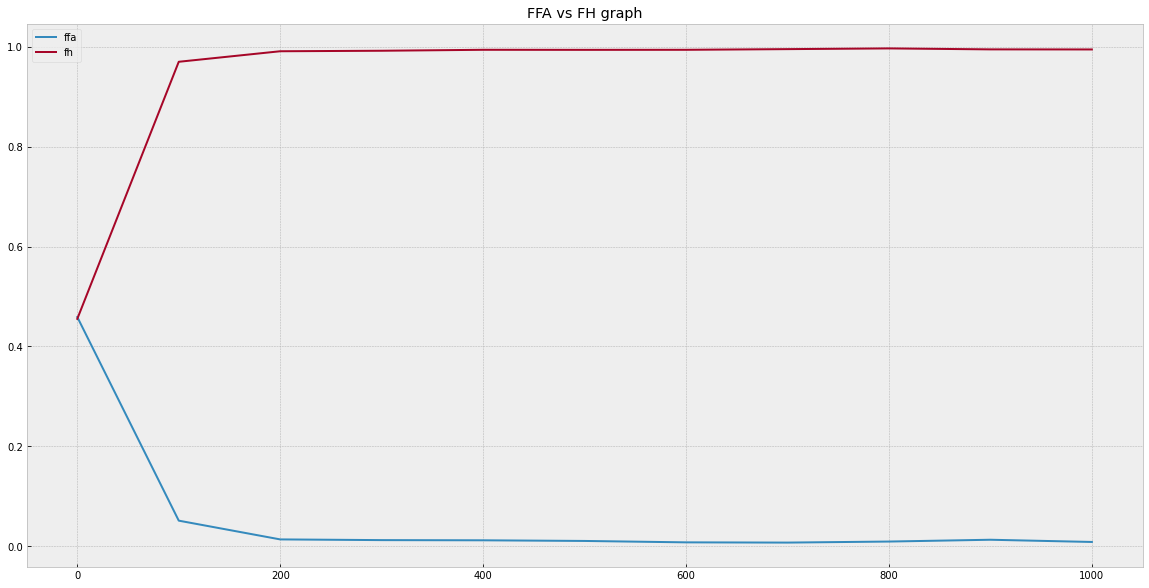

In [34]:
plt.figure(figsize=(20,10))
plt.plot(range(0, 1100, 100), ffa, label='ffa')
plt.plot(range(0, 1100, 100), fh, label='fh')

plt.title("FFA vs FH graph")
plt.legend()

### At 200 epochs we achieve FH and FFA scores of 0.99 and 0.13 respectively, which is why we have chosed to run the experiments with 200 epochs

In [35]:
model = DeepNet(layerSize=[256]+[256]*3+[256])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(data, data, model, criterion, optimizer, 200)

## 3. Testing the model

### Displaying the predicted images for running the model on dataset #1

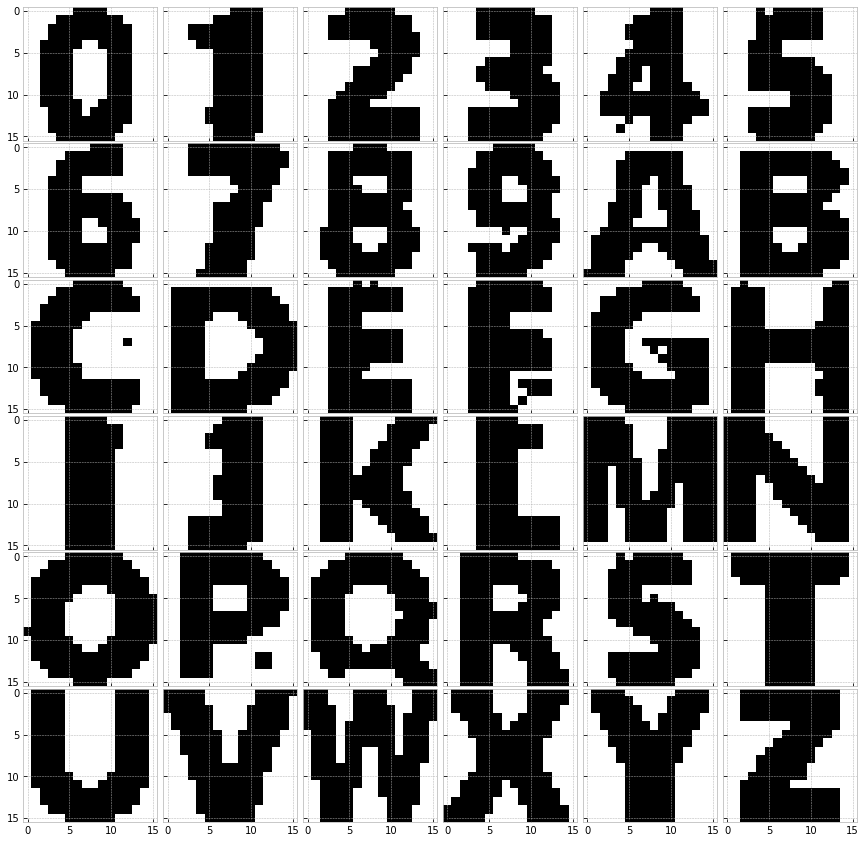

In [49]:
pred, err = test(data=data, target=data, model=model)
fig = plt.figure(figsize=(15, 15))
fh_e += err[0]
ffa_e += err[1]
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    

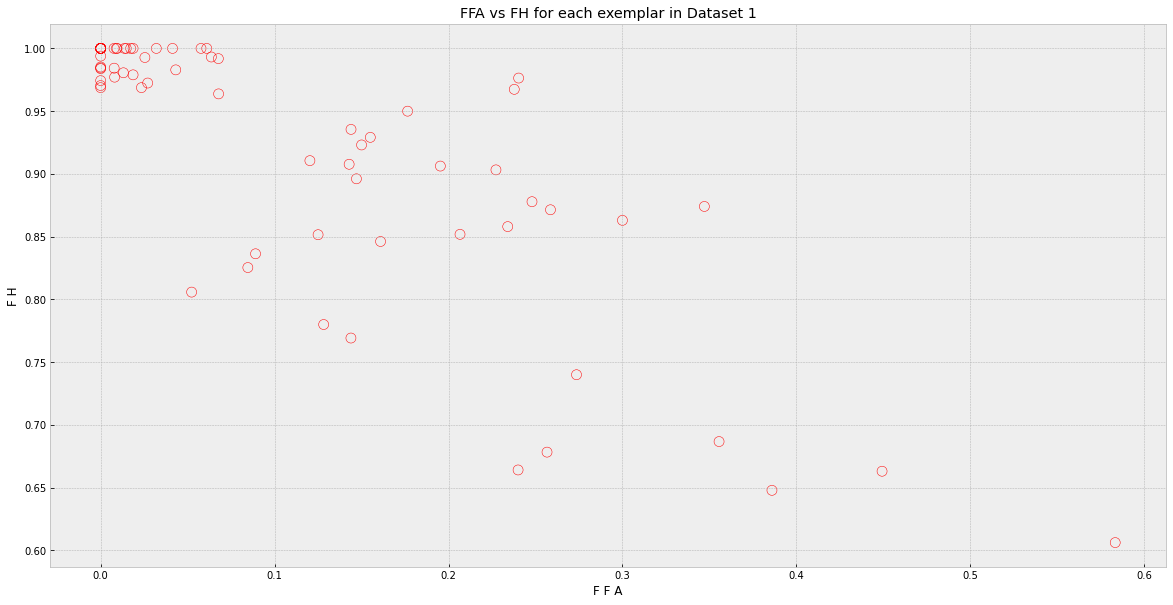

In [64]:
plt.figure(figsize=(20,10))
plt.scatter(ffa_e, fh_e, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.show()

### reading the dataset #2

In [65]:
#read images
serif=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/serif/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    serif.append(np.array(final_img, dtype=np.float32).flatten())


### Testing the model against dataset #2

[0.1686950642325896, 0.1936808314352487, 0.12504231116333067] [0.8727513227513228, 0.8522296491117277, 0.10634889288770355]


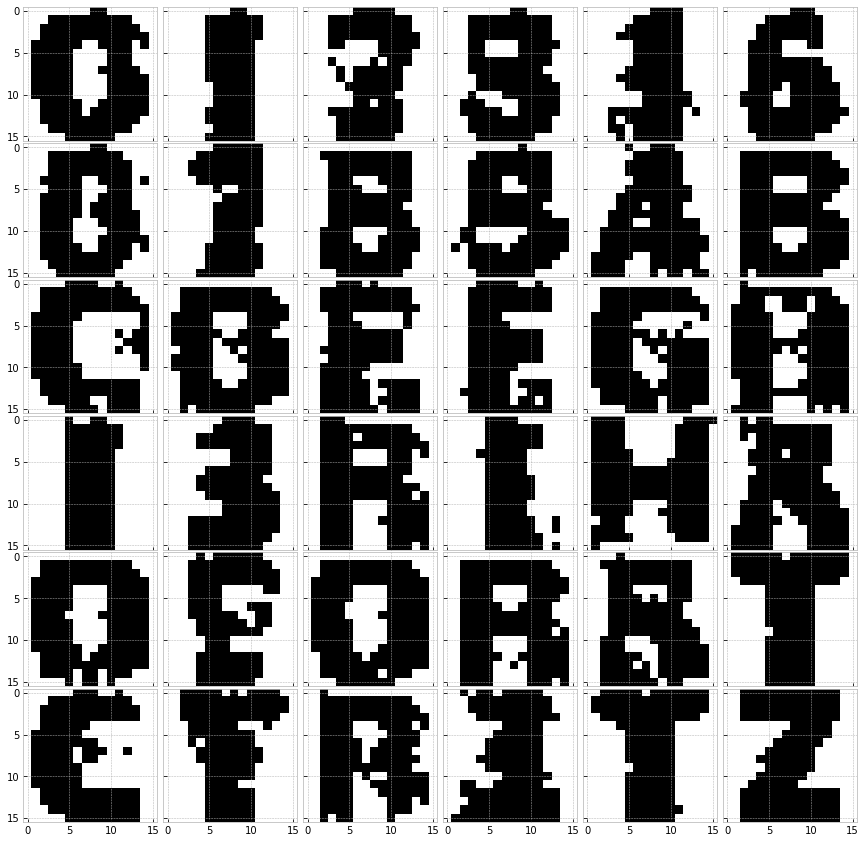

In [66]:
fh_e, ffa_e = [], []
pred, err = test(data=serif, target=data, model=model)

fh_e += err[0]
ffa_e += err[1]

fh = [np.median(err[0]), np.mean(err[0]), np.std(err[0])]
ffa = [np.median(err[1]), np.mean(err[1]), np.std(err[1])]
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    
print(ffa, fh)

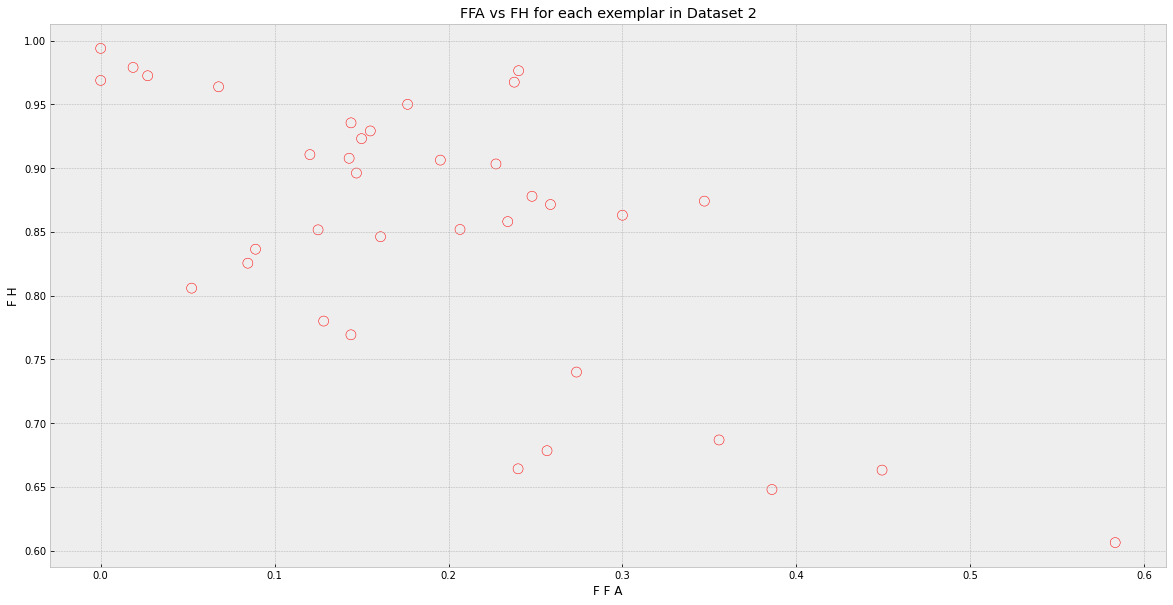

In [68]:
plt.figure(figsize=(20,10))
plt.scatter(ffa_e, fh_e, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 2")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.show()

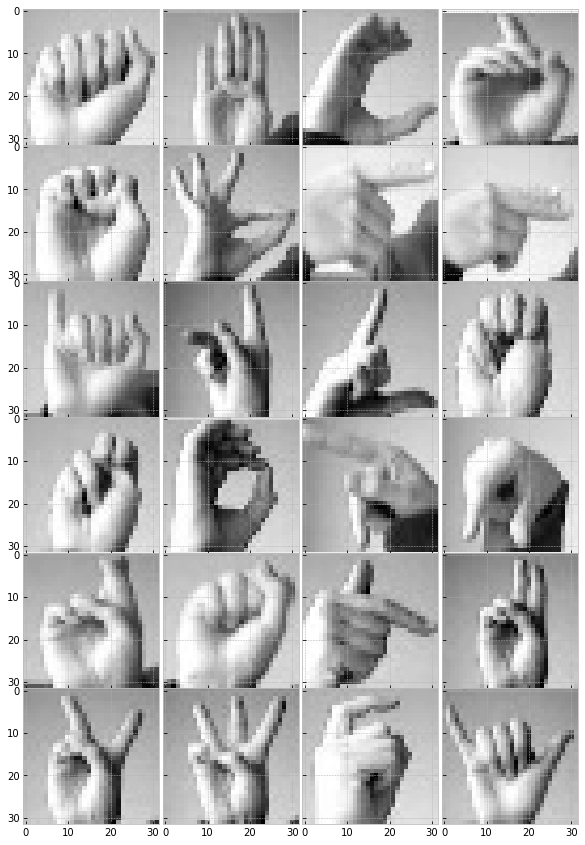

In [35]:
asl = []
asl_targets = []
ach = [i for i in range(65, 65+25)]
ach.remove(ord('J'))
for i in ach:
    img = cv2.imread('dataset/asl/32px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im = np.array(img_gray, dtype=np.float32).flatten()
    im = im/255
    asl.append(im)
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    asl_targets.append(np.array(final_img, dtype=np.float32).flatten())
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(asl[i].reshape(32, 32), 'gray')

In [37]:
ffa = []
fh = []
for epochs in range(100, 1100, 100):
    model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    train(asl, asl_targets, model, criterion, optimizer, epochs)
    pred, err = test(data=asl, target=asl_targets, model=model)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


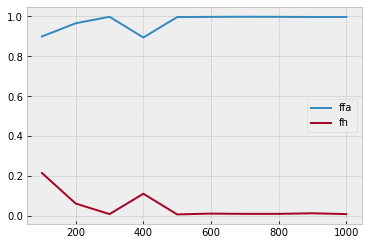

In [38]:
plt.figure()
plt.plot(range(100, 1100, 100), ffa, label='ffa')
plt.plot(range(100, 1100, 100), fh, label='fh')
plt.legend()    

In [41]:
model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(asl, asl_targets, model, criterion, optimizer, 300)

[1.0, 0.9974987274999648, 0.005796708462368311] [0.0, 0.012093854663576384, 0.015079648580935776]


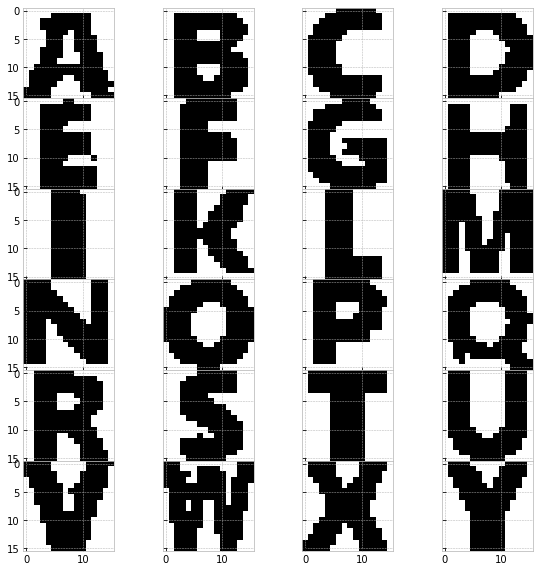

In [42]:
pred, err = test(data=asl, target=asl_targets, model=model)
ffa = [np.median(err[0]), np.mean(err[0]), np.std(err[0])]
fh = [np.median(err[1]), np.mean(err[1]), np.std(err[1])]
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(pred[i], 'gray')    
print(ffa, fh)